# Generate samples for the Deforestation Paper with multi-temporal stack

In [1]:
import sys
import os
# import pylab as plt
import numpy as np
# from matplotlib.colors import ListedColormap
# from osgeo import gdal
# from osgeo import ogr
from importlib import reload
# import skimage

sys.path.insert(0, '../../src')
import deepgeo.dataset.dataset_generator as dsgen
import deepgeo.dataset.rasterizer as rstzr
import deepgeo.dataset.preprocessor as prep
import deepgeo.dataset.sequential_chips as seq_cg
import deepgeo.common.geofunctions as gf
import deepgeo.common.visualization as vis

# reload(dtaug)
reload(rstzr)
reload(prep)
reload(seq_cg)
# reload(fs)
reload(gf)
reload(vis)

%matplotlib inline

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Input Files
DATA_DIR = "/home/raian/doutorado/Dados/generated"
shape_file = os.path.join(DATA_DIR, 'Prodes_mosaic.shp')
raster_files = [#os.path.join(DATA_DIR, "stacked_mosaic_2013_2014.tif"),
#                 os.path.join(DATA_DIR, "stacked_mosaic_2014_2015.tif"),
#                 os.path.join(DATA_DIR, "stacked_mosaic_2015_2016.tif"),
#                 os.path.join(DATA_DIR, "stacked_mosaic_2016_2017.tif")] #,
                os.path.join(DATA_DIR, "stacked_mosaic_2017_2018.tif")]

classes_of_interest = [['d2018']] # ['d2014'], ['d2015'], ['d2016'], ['d2017']] #, ['d2018']]
non_class = "not_deforestation"
class_column = "class_name"
class_names = ['not_deforestation', 'deforestation']

# Output Files
output_path = DATA_DIR
# fs.mkdir(output_path)
out_labels = [#os.path.join(output_path, 'labels_2014.tif'),
              #os.path.join(output_path, 'labels_2015.tif'),
              #os.path.join(output_path, 'labels_2016.tif'),
              #os.path.join(output_path, 'labels_2017.tif')] #,
              os.path.join(output_path, 'labels_2018.tif')]
# output_shp = os.path.join(output_path, "new_samples.shp")
output_ds = os.path.join(output_path, 'dataset_286x286_no_samp_cl-2013-2017')
ds_file_name = 'dataset'

# number_of_samples = 5000
chip_size = 286

## Rasterize the input shape file

SHAPE:  (11534, 13587, 1)


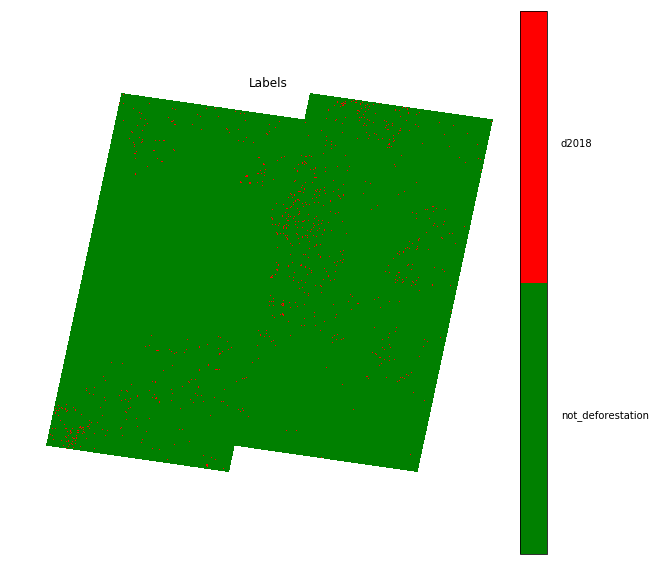

In [3]:
rasterized_layers = []
for year in range(0, len(classes_of_interest)):
    rasterizer = rstzr.Rasterizer(shape_file,
                                  raster_files[year],
                                  class_column,
                                  classes_interest=classes_of_interest[year],
                                  non_class_name=non_class)

    rasterizer.collect_class_names()
    rasterizer.rasterize_layer()
    m_class_names = rasterizer.get_class_names()
#     rasterizer.remove_labels_under_cloud(pos_qa=6, new_label=1)
    rasterized_layers.append(rasterizer.get_labeled_raster())
    rasterizer.save_labeled_raster_to_gtiff(out_labels[year])
    print('SHAPE: ', rasterized_layers[year].shape)
    
    vis.plot_labels(rasterized_layers[year], m_class_names, colors=["green", "red"])

In [4]:
# vis.plot_labels(rasterized_layer, class_names, colors=["green", "red"])

# values, count = np.unique(rasterized_layer, return_counts=True)
# print("UNIQUE: ", values, count)

# defor_proportion = count[1] / (count[0] + count[1])
# non_defor_proportion = count[0] / (count[0] + count[1])
# print('Deforestation Proportion: ', defor_proportion)
# print('Non deforestation Proportion: ', non_defor_proportion)

# print('Ratio: ', non_defor_proportion / defor_proportion)

In [7]:
reload(prep)
raster_arrays = []
for file in raster_files:
    preproc = prep.Preprocessor(file, no_data=-9999)
    preproc.set_nodata_value(-10)
    preproc.remove_bands([0, 6])
    original_raster = preproc.get_raster_stacked_raster()

#     vis.plot_image_histogram(original_raster, cmap=["green", "red", "cyan", "blue", "yellow"],
#                              title="Original Raster", legend=["Green", "Red", "NIR", "SWIR 1", "SWIR 2"])
#     vis.plot_rgb_img(original_raster, bands=[8,7,6], contrast=True)
    
    preproc.standardize_image()
    raster_arrays.append(preproc.get_raster_stacked_raster())
    print('SHAPE: ', preproc.get_raster_stacked_raster().shape)

SHAPE:  (11534, 13587, 10)
SHAPE:  (11534, 13587, 10)
SHAPE:  (11534, 13587, 10)
SHAPE:  (11534, 13587, 10)


In [ ]:
# for array in raster_arrays:
#     vis.plot_image_histogram(array, cmap=["green", "red", "cyan", "blue", "yellow"],
#                              title="Standardized Raster", legend=["Green", "Red", "NIR", "SWIR 1", "SWIR 2"])

In [8]:
# reload(dsgen)
generator = dsgen.DatasetGenerator(raster_arrays, rasterized_layers)
params = {'win_size': chip_size}
generator.generate_chips(params)
chip_struct = generator.get_samples()
# vis.plot_chips(chip_struct, raster_arrays[0], bands=[8, 7, 6], contrast=False)
generator.remove_no_data()
generator.shuffle_ds()
generator.split_ds()
generator.save_to_disk(output_ds, ds_file_name)
# chip_struct = generator.get_samples()
# vis.plot_chips(chip_struct, raster_arrays[0], bands=[8, 7, 6], contrast=False)

# =========================================
# TODO: Move this dataset generation to a .py 
# file and keep this notebook only for plotting strategies.
# Put progress bar here
# =========================================

In [ ]:
# chip_struct = {'chips': [],
#                'labels': [],
#                'classes': class_names}
# for i in range(0, len(raster_arrays)):
#     params = {'raster_array': raster_arrays[i],
#               'labels_array': rasterized_layers[i],
#               'win_size': chip_size}

#     chips_seq = seq_cg.SequentialChipGenerator(params).generate_chips()
#     vis.plot_chips(chips_seq, raster_arrays[i], bands=[8, 7, 6], contrast=False)
#     print(chips_seq['chips'].shape)
#     chip_struct['chips'].append(chips_seq['chips'])
#     chip_struct['labels'].append(chips_seq['labels'])

# chip_struct['chips'] = np.concatenate(chip_struct['chips'], axis=0)
# chip_struct['labels'] = np.concatenate(chip_struct['labels'], axis=0)

In [ ]:
# print(chip_struct['chips'].shape)
# print(chip_struct['labels'].shape)
# print(chip_struct['classes'])